# Build a contextual text and image search engine for product recommendations using Amazon Bedrock (Titan Multimodal Embedding) and Amazon OpenSearch Serverless

The solution presented provides an implementation for building a Amazon Titan Multilodal Embedding Model powered search engine prototype to retrieve and recommend products based on text or image queries. This is a step-by-step guide on how to use [Amazon Bedrock Titan models](https://aws.amazon.com/bedrock/titan) to encode images and text into embeddings, ingest embeddings into [Amazon OpenSearch Service](https://aws.amazon.com/opensearch-service/) index, and query the index using OpenSearch Service [k-nearest neighbors (KNN) functionality](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/knn.html).


It's recommended to execute the notebook in SageMaker Studio Notebooks `Python 3.0(Data Science)` Kernel with `ml.t3.medium` instance.

In [ ]:
%load_ext autoreload
%autoreload 2

Install dependencies

In [ ]:
!pip install opensearch-py
!pip install requests-aws4auth
!pip install -U boto3
!pip install -U botocore
!pip install -U awscli
!pip install -U seaborn

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## 1. Setup

Install some python packages we are going to use in the POC. For the sake of abstraction, we have defined all important function used in this notebook in utils.py

In [2]:
import boto3
import pandas as pd
import os
import re
import boto3
import json
import time
import base64
import logging
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO


from tqdm import tqdm
from urllib.parse import urlparse
from multiprocessing.pool import ThreadPool

import sagemaker
from utils import *
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')
aoss_client = boto3.client('opensearchserverless')

bedrock_client = boto3.client(
    "bedrock-runtime", 
    "us-east-1", 
    endpoint_url="https://bedrock-runtime.us-east-1.amazonaws.com"
)

In [4]:
session = boto3.session.Session()
region_name = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region, account_id

('us-east-1', '017444429555')

In [5]:
# Create a SageMaker session
sagemaker_role_arn = sagemaker.get_execution_role()
sagemaker_role_arn

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


'arn:aws:iam::017444429555:role/Admin'

## 2. Load publically available dataset

For this notebook, you are using the Amazon Berkeley Objects Dataset. The dataset is a collection of 147,702 product listings with multilingual metadata and 398,212 unique catalog images. 8,222 listings come with turntable photography. You will only make use of the item images and item name in US English (which is we consider as the product’s short description). For demo purposes you are going to use about 1,600 products for this practice. 

### 2.1 Data overview and preparation

Load the metadata

You can use pandas to load metadata, then select products which have titles in US English from the data frame. You will use a column called main_image_id to merge item name with item image later.

In [6]:
meta = pd.read_json("s3://amazon-berkeley-objects/listings/metadata/listings_0.json.gz", lines=True)
def func_(x):
    us_texts = [item["value"] for item in x if item["language_tag"] == "en_US"]
    return us_texts[0] if us_texts else None

meta = meta.assign(item_name_in_en_us=meta.item_name.apply(func_))
meta = meta[~meta.item_name_in_en_us.isna()][["item_id", "item_name_in_en_us", "main_image_id"]]
print(f"#products with US English title: {len(meta)}")
meta.head()

/opt/conda/lib/python3.10/site-packages/fsspec/registry.py:273: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


#products with US English title: 1655


,item_id,item_name_in_en_us,main_image_id
7,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL
18,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL
22,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL
38,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL
39,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L


You should be able to see over 1600 products in the data frame.
Next, you can link the item names with item images. `images/metadata/images.csv.gz` contains Image metadata. This file is a gzip-compressed comma-separated value (CSV) file with the following columns: `image_id`, `height`, `width`, and `path`. You can read the meta data file and then merge it with item metadata.

In [7]:
image_meta = pd.read_csv("s3://amazon-berkeley-objects/images/metadata/images.csv.gz")
dataset = meta.merge(image_meta, left_on="main_image_id", right_on="image_id")

In [8]:
# Create a new column in dataset with FULL PATH of the image
dataset = dataset.assign(img_full_path=f's3://amazon-berkeley-objects/images/small/' + dataset.path.astype(str))
dataset

,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg,s3://amazon-berkeley-objects/images/small/07/0...
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg,s3://amazon-berkeley-objects/images/small/c9/c...
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg,s3://amazon-berkeley-objects/images/small/c6/c...
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg,s3://amazon-berkeley-objects/images/small/2b/2...
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg,s3://amazon-berkeley-objects/images/small/2c/2...
...,...,...,...,...,...,...,...,...
1644,B07JCDQWM6,Amazon Brand – Rivet Thomas Modern Leather Sof...,71e51Rb1h4L,71e51Rb1h4L,2560,2560,c4/c4c46850.jpg,s3://amazon-berkeley-objects/images/small/c4/c...
1645,B07B1LZQWL,"Salmon Cake with Confetti Grains, 12.17 oz",91qFxcWDtjL,91qFxcWDtjL,1982,2560,01/0111c309.jpg,s3://amazon-berkeley-objects/images/small/01/0...
1646,B073P17SZZ,Amazon Brand – Rivet Blue Ocean Waves Print Wa...,91NCaDVKPEL,91NCaDVKPEL,1719,2560,85/85d5420a.jpg,s3://amazon-berkeley-objects/images/small/85/8...
1647,B07JQX8S2X,Amazon Basics Tufted Outdoor Square Seat Patio...,91XM523rZgL,91XM523rZgL,2560,2560,45/45e8e821.jpg,s3://amazon-berkeley-objects/images/small/45/4...


You can have a look at one sample image from the dataset by running the following code

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set


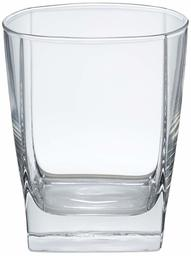

In [9]:
image, item_name = get_image_from_item_id_s3(item_id = "B0896LJNLH", dataset = dataset, image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

## 3. Generate embedding from item images

Amazon Titan Multimodal Embeddings G1 Generation 1 (G1) is able to project both images and text into the same latent space, so we only need to encode item images or texts into embedding space. In this practice, you can use [batch inference](https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html) to encode item images. Before creating the job, you need to copy item images from Amazon Berkeley Objects Dataset public S3 bucket to your own S3 Bucket. The operation needs take less than 10 mins.

But for this notebook, we'll use real-time API than batch inference. 

In [ ]:
%%time
multimodal_embeddings_img = []

for idx, path in enumerate(dataset['img_full_path']):
    embedding = get_titan_multimodal_embedding(image_path=path, dimension=1024)["embedding"]
    multimodal_embeddings_img.append(embedding)

dataset = dataset.assign(embedding_img=multimodal_embeddings_img)

In [ ]:
dataset.head()

### 3.1 Visualize the Image Embedding
Let's visualize the embedding 

In [ ]:
plot_similarity_heatmap(multimodal_embeddings_img[:20], multimodal_embeddings_img[:20])

### 3.2 [OPTIONAL] Store datset

In [ ]:
# Store dataset
# dataset.to_csv('dataset.csv', index = False)

## 4. Create a vector store - OpenSearch Serverless index

Before creating the new vector search collection and index, we must first create three associated OpenSearch policies: encryption security policy, network security policy, and data access policy. 

In [12]:
import random
suffix = random.randrange(200, 900)

identity = boto3.client('sts').get_caller_identity()['Arn']

def create_policies_in_oss(vector_store_name, aoss_client, role_arn):
    
    encryption_policy_name = f"titan-mm-sample-sp-{suffix}"
    network_policy_name = f"titan-mm-sample-np-{suffix}"
    access_policy_name = f'titan-mm-sample-ap-{suffix}'

    try:
        encryption_policy = aoss_client.create_security_policy(
            name=encryption_policy_name,
            policy=json.dumps(
                {
                    'Rules': [{'Resource': ['collection/' + vector_store_name],
                               'ResourceType': 'collection'}],
                    'AWSOwnedKey': True
                }),
            type='encryption'
        )
    except Exception as ex:
        print(ex)
    
    try:
        network_policy = aoss_client.create_security_policy(
            name=network_policy_name,
            policy=json.dumps(
                [
                    {'Rules': [{'Resource': ['collection/' + vector_store_name],
                                'ResourceType': 'collection'}],
                     'AllowFromPublic': True}
                ]),
            type='network'
        )
    except Exception as ex:
        print(ex)
    
    try:
        
        access_policy = aoss_client.create_access_policy(
            name=access_policy_name,
            policy=json.dumps(
                [
                    {
                        'Rules': [
                            {
                                'Resource': ['collection/' + vector_store_name],
                                'Permission': [
                                    'aoss:CreateCollectionItems',
                                    'aoss:DeleteCollectionItems',
                                    'aoss:UpdateCollectionItems',
                                    'aoss:DescribeCollectionItems'],
                                'ResourceType': 'collection'
                            },
                            {
                                'Resource': ['index/' + vector_store_name + '/*'],
                                'Permission': [
                                    'aoss:CreateIndex',
                                    'aoss:DeleteIndex',
                                    'aoss:UpdateIndex',
                                    'aoss:DescribeIndex',
                                    'aoss:ReadDocument',
                                    'aoss:WriteDocument'],
                                'ResourceType': 'index'
                            }],
                        'Principal': [identity, role_arn],
                        'Description': 'Easy data policy'}
                ]),
            type='data'
        )
    except Exception as ex:
        print(ex)
        
    return encryption_policy, network_policy, access_policy

### 4.1 create a new collection of type VECTORSEARCH

In [13]:
# Create Collection
vector_store_name = f'titan-mm-image-collection-{suffix}'

encryption_policy, network_policy, access_policy = create_policies_in_oss(vector_store_name=vector_store_name,
                       aoss_client=aoss_client,
                       role_arn=sagemaker_role_arn)

In [14]:
 collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

### 4.2 Setting up the Amazon OpenSearch Serverless index using KNN settings

Once the OpenSearch collection is created, create an index to store the item meta data and the embeddings. The index settings must be configured beforehand to enable the KNN functionality using the following configuration:

In [15]:
collection_id = collection['createCollectionDetail']['id']
host = collection_id + '.' + region_name + '.aoss.amazonaws.com'
print(host)

v2l58z14k2r8gtah0um3.us-east-1.aoss.amazonaws.com


In [16]:
service = 'aoss'
credentials = boto3.Session().get_credentials()
awsauth = AWSV4SignerAuth(credentials, region_name, service)

index_name = f"titam-mm-index"
index_body = {
   "settings": {
      "index.knn": "true"
   },
   "mappings": {
      "properties": {
         "image_vector": {
            "type": "knn_vector",
            "dimension": 1024 # Embedding size for Amanon Titan Multimodal Embedding G1 model, it is 1,024 (default), 384, 256
         },
         "description": {"type": "text"},
          "item_id" : {"type": "text"},
         "image_url": {"type": "text"}
      }
   }
}
# Build the OpenSearch client
oss_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)
# # It can take up to a minute for data access rules to be enforced
time.sleep(60)

To confirm its creation, we can retrieve the description of the new vector index you just created

In [17]:
# We would get an index already exists exception if the index already exists, and that is fine.
try:
    response = oss_client.indices.create(index_name, body=index_body)
    print(f"response received for the create index -> {response}")
except Exception as e:
    print(f"error in creating index={index_name}, exception={e}")

response received for the create index -> {'acknowledged': True, 'shards_acknowledged': True, 'index': 'titam-mm-index'}


In [18]:
# deleting indices
# aoss_client.indices.delete(index=index_name)

### 4.3 Ingest the image embeddings

Next you need to loop through your dataset and ingest items data into the cluster. A more robust and scalable solution for the embedding ingestion can be found in [Ingesting enriched data into Amazon ES](https://aws.amazon.com/blogs/industries/novartis-ag-uses-amazon-elasticsearch-k-nearest-neighbor-knn-and-amazon-sagemaker-to-power-search-and-recommendation/). The data ingestion for this POC should finish within 60 seconds. It also executes a simple query to verify the data have been ingested into the index.

In [19]:
%%time
import tqdm.notebook as tq

for idx, record in tq.tqdm(dataset.iterrows(), total=len(dataset)):
    document = {
                'image_vector': dataset['embedding_img'][idx],
                "description":   dataset['item_name_in_en_us'][idx],
                "item_id" : dataset['item_id'][idx],
                "image_url": dataset['img_full_path'][idx],  
                }
    response = oss_client.index(
    index = index_name,
    body = document
    )

  0%|          | 0/1649 [00:00<?, ?it/s]

CPU times: user 7.98 s, sys: 680 ms, total: 8.66 s
Wall time: 7min 30s


## 5. Perform a real-time Multimodal Search

Now that you have a working OpenSearch index to contain embeddings for your inventory, let's have a look at how you can generate embedding for new items. You'll use Amazon Titan Multimodal Embeddings G1 Generation 1 (G1) extracting text features and image features. 

Let’s take a look at the results of a simple query. After retrieving results from the OpenSearch service, we get the item names and images from dataset.

### 5.1. Perform Image Search based on Text Input

Let’s take a look at the results of a simple query. In below example, we'll receive an text input i.e. "drinkware glass" from user, and then will send it to search engine to find the similar items.

In [20]:
query_prompt = "drinkware glass"

Find the similar items based on use queries. You can see that we found glass drinkware from our dataset based on the input query. That's what we want to achieve.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


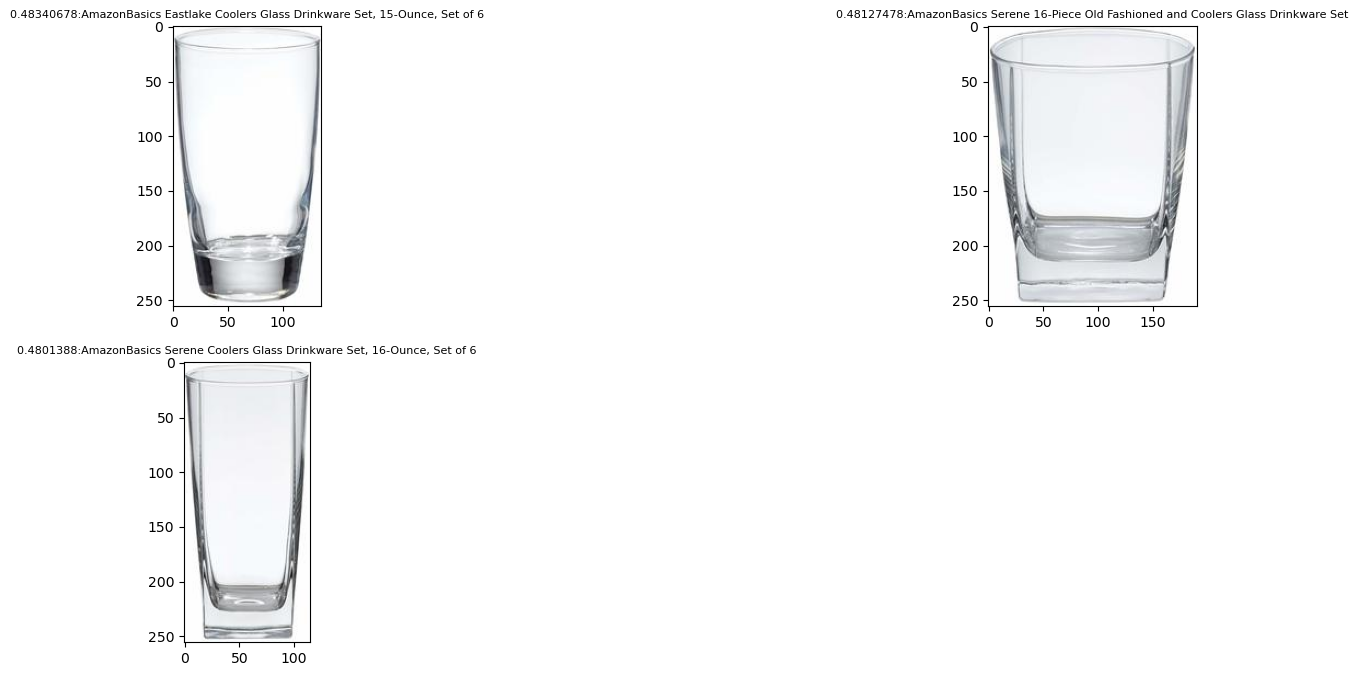

In [21]:
similar_items = find_similar_items_from_query(query_prompt = query_prompt, k=5, num_results=3, index_name=index_name, dataset = dataset, 
                                   open_search_client = oss_client, image_root_path=f's3://amazon-berkeley-objects/images/small/')

display_images(similar_items)

### 5.2 Perform Image Search based on Image Input

Let’s take a look at the results based on a simple image. The input image will get coverted into vector embeddings and based on the similarity search, it will return the result,

You can use any image, but for below example, we'll select a random image from the above dataset based on item_id (for ex. item_id = "B07JCDQWM6" ),  and then will send this image to search engine to find the similar items. First, Let's get the image amd image location based on the item id.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Amazon Brand – Rivet Thomas Modern Leather Sofa Couch, 81.5"W, Chestnut


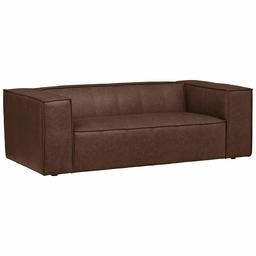

In [22]:
item_id = "B07JCDQWM6"

image, item_name = get_image_from_item_id_s3(item_id = item_id, dataset = dataset, image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

Then, get the similar items based on the image above

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


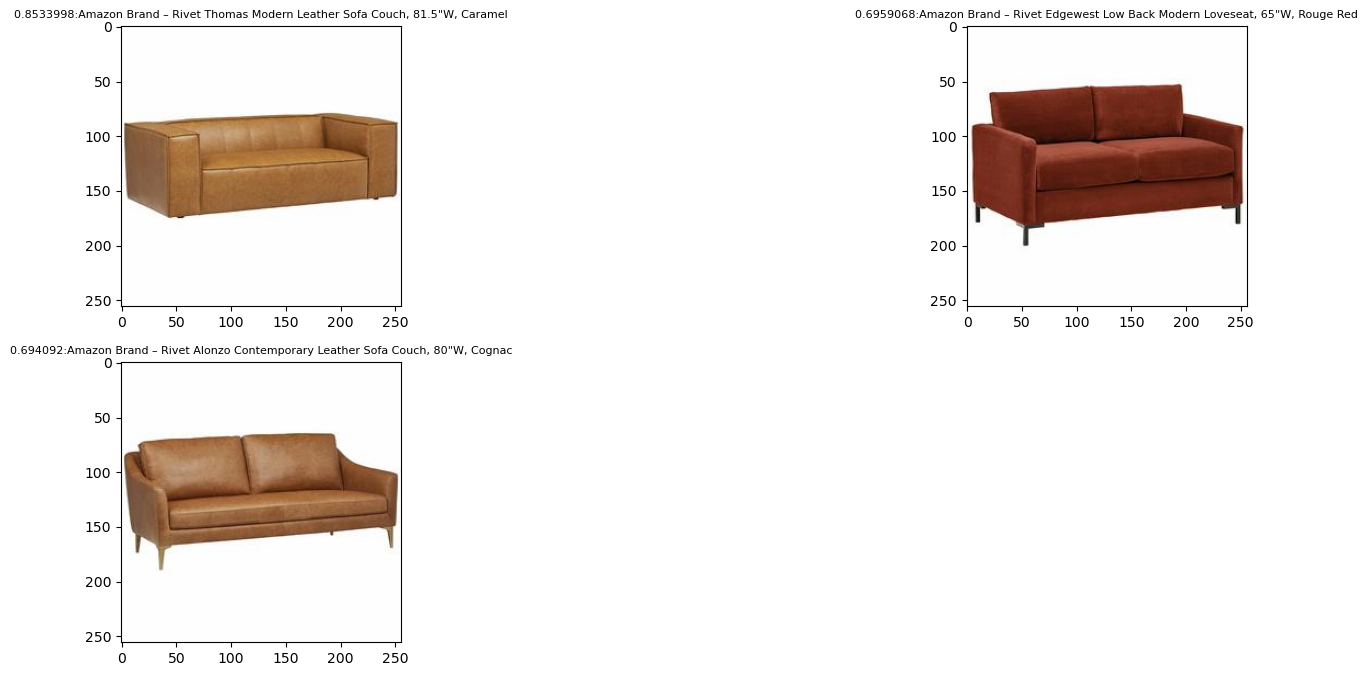

In [23]:
item_id = "B07JCDQWM6"
search_image_path = dataset[dataset['item_id']==item_id]['img_full_path'].iloc[0]

similar_items = find_similar_items_from_image(image_path = search_image_path, k=5, num_results=3, index_name=index_name, dataset = dataset, 
                                   open_search_client = oss_client, image_root_path=f's3://amazon-berkeley-objects/images/small/')

display_images(similar_items)

## 6. Clean up

When you finish this exercise, remove your resources with the following steps:

Delete vector index.
Delete data, network, and encryption access ploicies.
Delete collection.
Delete SageMaker Studio user profile and domain.
Optionally, empty and delete the S3 bucket, or keep whatever you want.  

In [24]:
# delete vector index
oss_client.indices.delete(index=index_name)

# delete data, network, and encryption access ploicies
aoss_client.delete_access_policy(type="data", name=access_policy['accessPolicyDetail']['name'])
aoss_client.delete_security_policy(type="network", name=network_policy['securityPolicyDetail']['name'])
aoss_client.delete_security_policy(type="encryption", name=encryption_policy['securityPolicyDetail']['name'])

# delete collection
collection_id = collection['createCollectionDetail']['id']
aoss_client.delete_collection(id=collection_id)

{'deleteCollectionDetail': {'id': 'v2l58z14k2r8gtah0um3',
  'name': 'titan-mm-image-collection-650',
  'status': 'DELETING'},
 'ResponseMetadata': {'RequestId': '2c9064dd-2b5f-47ca-bec4-0c2b8d32069d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2c9064dd-2b5f-47ca-bec4-0c2b8d32069d',
   'date': 'Thu, 08 Feb 2024 20:20:58 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '115',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}